# Tratar dados concatenados do Data Logger
Este notebook utiliza a biblioteca Pandas para tratar os dados concatenados no notebook `concatenar-dados-datalogger`.

---

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Charts styling
#plt.style.use('fivethirtyeight')
#plt.style.use('bmh')
plt.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8 # increases figure size
matplotlib.rcParams.update({'font.size': 14}) # increases chart font size
#rcParams['font.family'] = 'Arial Narrow'

## Dados bacia RB01

### Tratamento e limpeza dos dados

In [2]:
# Loads data from CSV file to Pandas DataFrame object
df1 = pd.read_csv('RB01_dados_concatenados.csv')
df1.head()

,Date,Time,Batt,SDI21,SDI22,SDI11,SDI01,SDI07
0,16/03/11,11:30:00,12.76,1.11,4,1.02,15.0,17.8
1,16/03/11,11:40:00,12.76,0.00,0,1.02,15.0,17.8
2,16/03/11,11:50:00,13.07,0.00,0,1.02,14.0,17.8
3,16/03/11,12:00:00,13.15,0.00,0,1.02,14.0,17.9
4,16/03/11,12:10:00,12.84,0.00,0,1.02,13.0,17.9


#### Curva-chave da Bacia RB01

In [3]:
def level_to_runoff_rb01 (level):
    """Runoff calculation, as described by Cardoso 2013, p.48"""
    if level <= 1.16:
        return 3.27*level**2.6
    
    elif (level > 1.16) & (level <= 2.21):
        return 3.11*level**2.93
    
    elif (level > 2.21): # & (level <= 2.25):
        return 1.34*level**3.98
        

In [4]:
# Drops unused columns and renames some
df1 = df1.drop(['Batt', 'SDI22', 'SDI01','SDI07'], axis=1)
df1 = df1.rename(index=str, columns={"SDI21": "Precipitation", "SDI11": "Level"})

# Manipulates DataFrame to create datetime format index
df1['Datetime'] = df1['Date'] + ' ' + df1['Time']
df1['Datetime'] = pd.to_datetime(df1['Datetime'], format='%d/%m/%y %H:%M:%S')
df1 = df1.drop(['Date', 'Time'], axis=1)
df1 = df1.set_index('Datetime', drop=False)
df1 = df1.sort_index()

# Fill the gaps by 'reindexing' from a perfectly spaced series (10min) 
idx = pd.date_range(df1.index.min(), df1.index.max(), freq='10min')
df1 = df1.reindex(idx)

# Creates an ajusted level column using auxiliary function defined here
df1['Aj_level'] = 0.7341*df1['Level']+0.0997

# Creates runoff column using auxiliary function defined above
df1['Runoff'] = df1['Aj_level'].apply(level_to_runoff_rb01)

# Creates additional necessary columns 
df1['Year'] = df1.index.year
df1['Day_year'] = df1.index.dayofyear
df1['Hour_day'] = df1.index.hour + df1.index.minute/60

df1.head()

,Precipitation,Level,Datetime,Aj_level,Runoff,Year,Day_year,Hour_day
2011-03-16 11:30:00,1.11,1.02,2011-03-16 11:30:00,0.848482,2.133136,2011,75,11.500000
2011-03-16 11:40:00,0.00,1.02,2011-03-16 11:40:00,0.848482,2.133136,2011,75,11.666667
2011-03-16 11:50:00,0.00,1.02,2011-03-16 11:50:00,0.848482,2.133136,2011,75,11.833333
2011-03-16 12:00:00,0.00,1.02,2011-03-16 12:00:00,0.848482,2.133136,2011,75,12.000000
2011-03-16 12:10:00,0.00,1.02,2011-03-16 12:10:00,0.848482,2.133136,2011,75,12.166667


In [5]:
# Saves file to CSV and Excel
#df1.to_csv('RB01_dados_limpos.csv')
#df1.to_excel('RB01_dados_limpos.xlsx')

### Análises

In [6]:
df = df1  # Makes a copy (to the rescue, here I am!)
df = df.loc['2012-01-01':'2013-12-31']  # Filters by date
df.head()

,Precipitation,Level,Datetime,Aj_level,Runoff,Year,Day_year,Hour_day
2012-01-01 00:00:00,0.0,0.83,2012-01-01 00:00:00,0.709003,1.337312,2012,1,0.000000
2012-01-01 00:10:00,0.0,0.83,2012-01-01 00:10:00,0.709003,1.337312,2012,1,0.166667
2012-01-01 00:20:00,0.0,0.83,2012-01-01 00:20:00,0.709003,1.337312,2012,1,0.333333
2012-01-01 00:30:00,0.0,0.83,2012-01-01 00:30:00,0.709003,1.337312,2012,1,0.500000
2012-01-01 00:40:00,0.0,0.82,2012-01-01 00:40:00,0.701662,1.301609,2012,1,0.666667


In [7]:
#df[['Precipitation', 'Runoff']].plot()

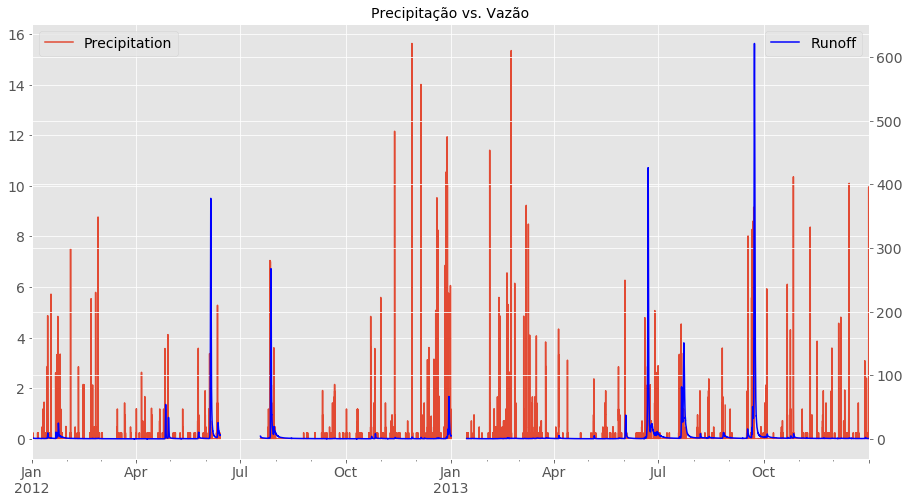

In [8]:
# Procedure to handle secondary Y axis
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()

y0 = df['Precipitation'].plot(ax=ax0)
y1 = df['Runoff'].plot(secondary_y=True, style='b', ax=ax1)
y0.legend(loc=2) # bar legend to the left
y1.legend(loc=0) # line legend to the right

plt.title('Precipitação vs. Vazão', fontsize=14)
plt.show()
plt.close()

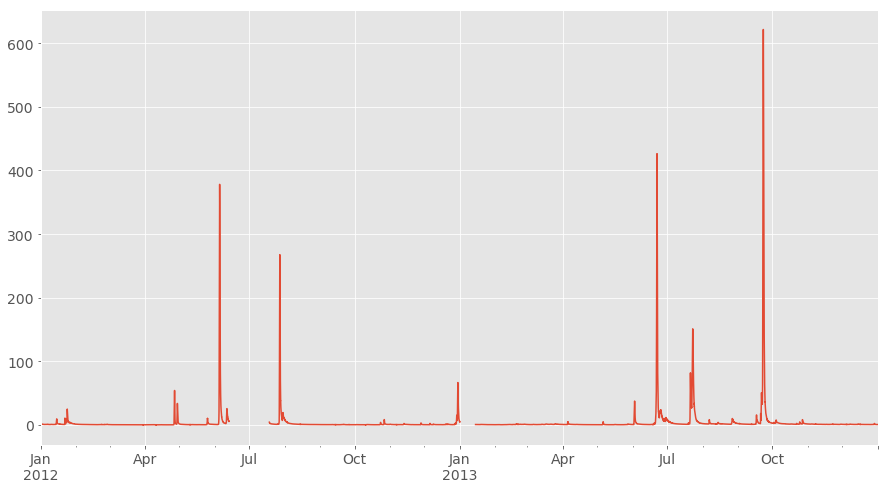

In [9]:
df['Runoff'].plot()

In [10]:
df['Runoff'].describe()

count    98167.000000
mean         4.144076
std         25.805027
min          0.282762
25%          0.554521
50%          0.852691
75%          1.473291
max        621.359879
Name: Runoff, dtype: float64

In [11]:
df['Level'].describe()

count    98167.000000
mean         0.834525
std          0.569344
min          0.395500
25%          0.552600
50%          0.676500
75%          0.866650
max          6.234400
Name: Level, dtype: float64

## Dados bacia RB10

In [12]:
# Loads data from CSV file to Pandas DataFrame object
df2 = pd.read_csv('RB10_dados_concatenados.csv')
df2.head()

,Date,Time,Batt,SDI01,SDI07,Ana1
0,16/12/11,13:10:00,14.08,2.92,20.6,0.092
1,16/12/11,13:20:00,14.08,3.41,20.7,0.091
2,16/12/11,13:30:00,14.08,2.66,20.9,0.091
3,16/12/11,13:40:00,13.92,3.23,21.0,0.091
4,16/12/11,13:50:00,14.08,2.89,20.7,0.092


#### Curva-chave bacia RB10

In [13]:
def level_to_runoff_rb10 (level):
    """Runoff calculation, as described by Cardoso 2013, p.48"""
    if level <= 0.98:
        return 2.51*level**2.04
    
    elif (level > 0.98) & (level <= 1.22):
        return 3.94*level-1.43
    
    elif (level > 1.22): # & (level <= 1.35):
        return 2.03*level**2.59

In [14]:
# Drops unused columns and renames some
df2 = df2.drop(['Batt', 'SDI01','SDI07'], axis=1)
df2 = df2.rename(index=str, columns={ "Ana1": "Level"})

# Manipulates DataFrame to create datetime format index
df2['Datetime'] = df2['Date'] + ' ' + df2['Time']
df2['Datetime'] = pd.to_datetime(df2['Datetime'], format='%d/%m/%y %H:%M:%S')
df2 = df2.drop(['Date', 'Time'], axis=1)
df2 = df2.set_index('Datetime', drop=False)
df2 = df2.sort_index()

# Fill the gaps by 'reindexing' from a perfectly spaced series (10min) 
idx = pd.date_range(df2.index.min(), df2.index.max(), freq='10min')
df2 = df2.reindex(idx)

# Creates an ajusted level column using auxiliary function defined here
df2['Aj_level'] = 0.7341*df2['Level']+0.0997

# Creates runoff column using auxiliary function defined above
df2['Runoff'] = df2['Aj_level'].apply(level_to_runoff_rb10)

# Creates additional necessary columns 
df2['Year'] = df2.index.year
df2['Day_year'] = df2.index.dayofyear
df2['Hour_day'] = df2.index.hour + df2.index.minute/60

df2.head()

,Level,Datetime,Aj_level,Runoff,Year,Day_year,Hour_day
2011-12-16 13:10:00,0.092,2011-12-16 13:10:00,0.167237,0.065354,2011,350,13.166667
2011-12-16 13:20:00,0.091,2011-12-16 13:20:00,0.166503,0.064770,2011,350,13.333333
2011-12-16 13:30:00,0.091,2011-12-16 13:30:00,0.166503,0.064770,2011,350,13.500000
2011-12-16 13:40:00,0.091,2011-12-16 13:40:00,0.166503,0.064770,2011,350,13.666667
2011-12-16 13:50:00,0.092,2011-12-16 13:50:00,0.167237,0.065354,2011,350,13.833333


In [15]:
rb10 = df2

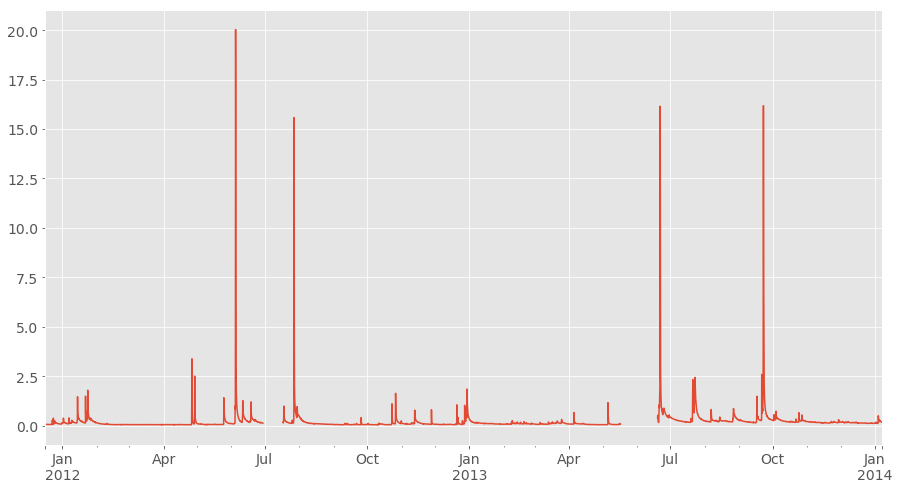

In [16]:
rb10['Runoff'].plot()

## Dados bacia RB11

In [17]:
# Loads data from CSV file to Pandas DataFrame object
df3 = pd.read_csv('RB11_dados_concatenados.csv')
df3.head()

,Date,Time,Batt,SDI01,SDI07,Ana1
0,16/12/11,10:30:00,13.43,2.44,17.6,0.060
1,16/12/11,10:40:00,13.51,2.36,17.7,0.059
2,16/12/11,10:50:00,13.59,2.39,17.8,0.059
3,16/12/11,11:00:00,13.67,2.25,17.9,0.059
4,16/12/11,11:10:00,13.67,2.40,18.1,0.059


#### Curva-chave RB11

In [18]:
def level_to_runoff_rb11 (level):
    """Runoff calculation, as described by Cardoso 2013, p.48"""
    if level <= 0.76:
        return 1.61*level**1.84
    
    elif (level > 0.76): # & (level <= 1.22):
        return 1.79*level**2.00
    


In [19]:
# Drops unused columns and renames some
df3 = df3.drop(['Batt', 'SDI01','SDI07'], axis=1)
df3 = df3.rename(index=str, columns={ "Ana1": "Level"})

# Manipulates DataFrame to create datetime format index
df3['Datetime'] = df3['Date'] + ' ' + df3['Time']
df3['Datetime'] = pd.to_datetime(df3['Datetime'], format='%d/%m/%y %H:%M:%S')
df3 = df3.drop(['Date', 'Time'], axis=1)
df3 = df3.set_index('Datetime', drop=False)
df3 = df3.sort_index()

# Fill the gaps by 'reindexing' from a perfectly spaced series (10min) 
idx = pd.date_range(df3.index.min(), df3.index.max(), freq='10min')
df3 = df3.reindex(idx)

# Creates an ajusted level column using auxiliary function defined here
df3['Aj_level'] = 0.7341*df3['Level']+0.0997

# Creates runoff column using auxiliary function defined above
df3['Runoff'] = df3['Aj_level'].apply(level_to_runoff_rb10)

# Creates additional necessary columns 
df3['Year'] = df3.index.year
df3['Day_year'] = df3.index.dayofyear
df3['Hour_day'] = df3.index.hour + df3.index.minute/60

df3.head()

,Level,Datetime,Aj_level,Runoff,Year,Day_year,Hour_day
2011-12-16 10:30:00,0.060,2011-12-16 10:30:00,0.143746,0.047992,2011,350,10.500000
2011-12-16 10:40:00,0.059,2011-12-16 10:40:00,0.143012,0.047493,2011,350,10.666667
2011-12-16 10:50:00,0.059,2011-12-16 10:50:00,0.143012,0.047493,2011,350,10.833333
2011-12-16 11:00:00,0.059,2011-12-16 11:00:00,0.143012,0.047493,2011,350,11.000000
2011-12-16 11:10:00,0.059,2011-12-16 11:10:00,0.143012,0.047493,2011,350,11.166667


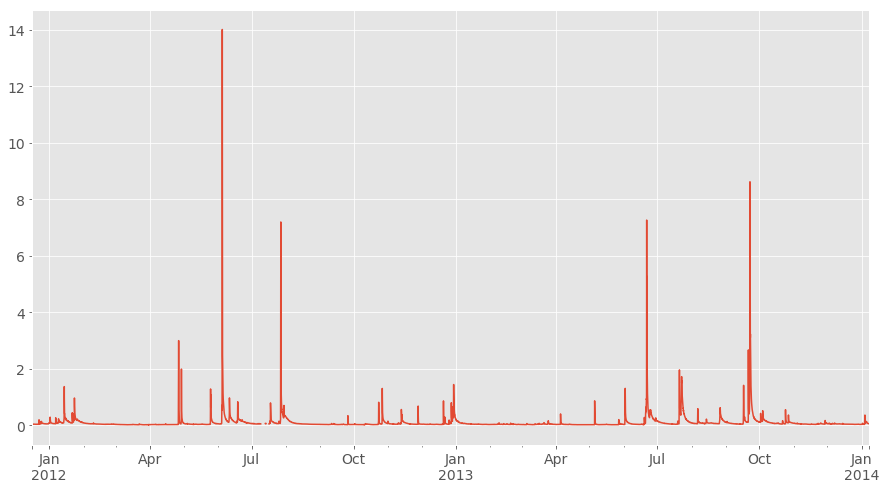

In [20]:
df3['Runoff'].plot()